# Домашнее задание №5

# Выполнил Салабай В.Р. (ФПэ-01-22)

Задание №1 


Оценить расходы в цилиндр высокого давления и в конденсатор турбины без промежуточного переграва пара.

Заданные параметр:
Номинальная электрическая мощность: 250 МВт; 
Начальное давление свежего пара: 23.5 МПа;
Начальная температура свежено пара: 540 C;
Конечное давление пара: 6.9 кПа;
Температура питательной воды: 263 C;
Число отборов: 8;
Механическое КПД: 99.2%;
КПД Электрогенератора: 99%;

In [84]:
#Загружаем библиотеки
import iapws
from iapws import IAPWS97 as gas

In [85]:
#СИ
MPa = 10 ** 6
kPa = 10 ** 3
MBт = 10 ** 6
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

In [86]:
# Исходные данные
electric_power = 250 * MBt 
p_0 = 23.5 * MPa 
t_0 = 540 
p_k = 6.9 * kPa 
z = 7
t_feed_water = 263
p_feed_water = 1.35 * p_0 #  рпв=(1,33-1,35)р0 при сверхкритических параметрах пара
t_nas_0 = 374.2 #– температура насыщения при давлении  пара р0 (при сверхкритическом давлении 374,2 С) 
mechanical_kpd = 0.992
generator_kpd = 0.99 
internal_kpd = 0.85 

In [87]:
# Определение параметров точек цикла,необходимые для расчета
delta_CVD = 0.05 * p_0 
real_p_0 = p_0 - delta_CVD
teor_point_0 = gas(P = p_0 * unit, T=to_kelvin(t_0))
point_0 = gas(P=real_p_0 * unit, h=teor_point_0.h)
point_feed_water = gas(P=p_feed_water * unit, T=to_kelvin(t_feed_water))
point_k_kip_water = gas(P=p_k * unit, x=0)
teor_point_k = gas(P=p_k * unit, s = teor_point_0.s)
heat_drop_i = ( teor_point_0.h - teor_point_k.h) * internal_kpd
h_k = teor_point_0.h - heat_drop_i
point_k = gas(P = p_k * unit, h = h_k)

In [88]:
# Расчет относительного КПД ЦВД
kpd_oi = (teor_point_0.h - point_k.h)/(teor_point_0.h - teor_point_k.h)
kpd_oi

0.85

In [89]:
# Расчет коэфициетна кси с бесконечным числом отборов  
numenator_without = point_k.T * (teor_point_0.s - point_k_kip_water.s)
denumenator_without = teor_point_0.h - point_k_kip_water.h
without_part = 1 - (numenator_without/denumenator_without)
numenator_inf = point_k.T * (teor_point_0.s - point_feed_water.s)
denumenator_inf =  teor_point_0.h - point_feed_water.h
inf_part = 1 - (numenator_inf / denumenator_inf)
ksi_inf = 1 - (without_part / inf_part)
ksi_inf

0.14709057780648582

In [90]:
# "x" -----> ((t_пв__t_k)(t_nas_0__t_k))
x = (point_feed_water.T - point_k.T) / (to_kelvin(t_nas_0) - point_k.T)
x

0.668521593152601

![image.png](https://s.iimg.su/s/26/th_Yob43C4AKM0uH1xWJQpcIzxeocyldc1YxZL9ugLm.png)

In [91]:
# Расчет коэфициетна кси с 7 числом отборов  
ksi = 0.86 * ksi_inf
ksi

0.1264978969135778

In [92]:
eff_num = (teor_point_0.h - teor_point_k.h) * internal_kpd
eff_denum =  teor_point_0.h - point_k_kip_water.h
kpd = (eff_num / eff_denum) * (1 + ksi)
kpd,eff_num,eff_denum

(0.42566658122520085, 1195.0407456230168, 3162.594730353387)

In [93]:
estimated_heat_drop = kpd * (teor_point_0.h - point_feed_water.h)
estimated_heat_drop

926.282537747384

In [94]:
vhod_mass_flow = electric_power / (estimated_heat_drop * 1000 * mechanical_kpd * generator_kpd)
vhod_mass_flow

274.8208415072751

In [95]:
mass_flow_denum = 1000 * (point_k.h - point_k_kip_water.h) * mechanical_kpd * generator_kpd
mass_flow_factor = (1/kpd) - 1
condensator_mass_flow = (electric_power * mass_flow_factor)/mass_flow_denum
condensator_mass_flow

174.5665451005368

In [96]:
print("Массовый расход (турбина: вход)", vhod_mass_flow)

Массовый расход (турбина: вход) 274.8208415072751


In [ ]:
print("Массовый расход (конденсатор):", condensator_mass_flow)

Задача 2
Написать автоматизированный поиск коэффициента с оси Y по данному значению оси Х для линии 7 в случае присутствия пром. перегрева (график с пары). Вывести полученный график коэффициентов.

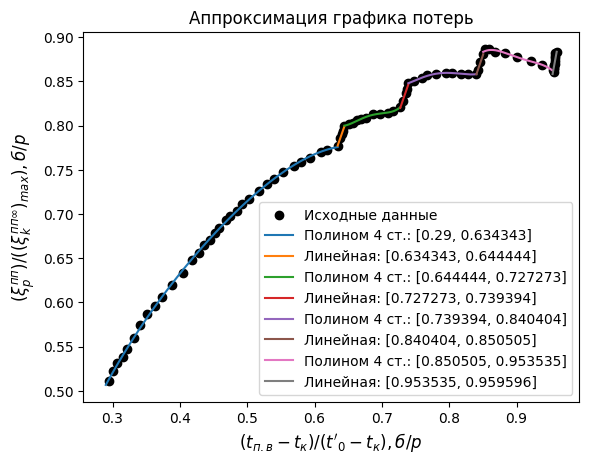

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# **Загрузка данных**
data = np.loadtxt('inf.txt', dtype=float, delimiter=';', comments=None)

# **Определение функций**
def polynomial_4(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def linear(x, m, c):
    return m * x + c

def piecewise_fit(data, intervals):
    x, y = data[:, 0], data[:, 1]  # Разделяем данные на x и y
    results = []

    for interval, func_type in intervals:
        # Применяем маску для выделения данных из интервала
        mask = (x >= interval[0]) & (x <= interval[1])
        x_segment, y_segment = x[mask], y[mask]

        # Фитирование данных в каждом интервале
        if func_type == "polynomial_4":
            params, _ = curve_fit(polynomial_4, x_segment, y_segment)
            results.append((interval, polynomial_4, params))
        elif func_type == "linear":
            params, _ = curve_fit(linear, x_segment, y_segment)
            results.append((interval, linear, params))
    
    return results

# **Определение интервалов и моделей**
intervals = [
    ([0.29, 0.634343], "polynomial_4"),
    ([0.634343, 0.644444], "linear"),
    ([0.644444, 0.727273], "polynomial_4"),
    ([0.727273, 0.739394], "linear"),
    ([0.739394, 0.840404], "polynomial_4"),
    ([0.840404, 0.850505], "linear"),
    ([0.850505, 0.953535], "polynomial_4"),
    ([0.953535, 0.959596], "linear")
]

# **Применение сегментного фитирования**
fitted_segments = piecewise_fit(data, intervals)

# **Визуализация данных**
plt.scatter(data[:, 0], data[:, 1], color="black", label="Исходные данные")  # Нанесение исходных точек

for interval, func, params in fitted_segments:
    x_fit = np.linspace(interval[0], interval[1], 1000)  # Создание точек для интервала
    y_fit = func(x_fit, *params)  # Вычисление значений функции на интервале
    fit_label = f"{'Полином 4 ст.' if func == polynomial_4 else 'Линейная'}: {interval}"
    plt.plot(x_fit, y_fit, label=fit_label)  # Нанесение графика аппроксимирующей функции

# **Оформление графика**
plt.legend()
plt.xlabel("$(t_{п.в} - t_{к}) / (t'_0 - t_{к}), б/р$", fontsize=12)
plt.ylabel("$(ξ^{пп}_p) / ((ξ^{пп∞}_k)_{max}), б/р$", fontsize=12)
plt.title("Аппроксимация графика потерь")
plt.show()